In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
plt.style.use('ggplot')
from scipy import stats
from statistics import mean, stdev
from math import sqrt
from tqdm.auto import tqdm
import warnings

warnings.filterwarnings('ignore')

<h1>Проект: вариант 2

<h2>Задание 1. A/B–тестирование

<span style="color:darkblue"> 1.1 Условие

<span style="color:darkblue"> Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.<span>

Загружаем исходные данные

In [77]:
groups = pd.read_csv('http://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/UhyYx41rTt3clQ', sep=';')
groups_add = pd.read_csv('http://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/5Kxrz02m3IBUwQ')
active_st = pd.read_csv('http://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ')
checks = pd.read_csv('http://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/pH1q-VqcxXjsVA', sep=';')

Объединяем таблицы, приводим данные в порядок

In [78]:
groups_2 = pd.concat([groups, groups_add], ignore_index=True)

In [79]:
active_st = active_st.rename(columns={'student_id': 'id'})
active_st['active'] = 'active'
checks = checks.rename(columns={'student_id': 'id'})

In [80]:
df = pd.merge(groups_2, active_st, how='left', on='id')

In [81]:
df = pd.merge(df, checks, how='left', on='id')

In [82]:
df = df.fillna(0)

In [83]:
df.head()

,id,grp,active,rev
0,1489,B,0,0.0
1,1627,A,active,990.0
2,1768,B,0,0.0
3,1783,B,0,0.0
4,1794,A,0,0.0


In [84]:
"""Проверяем как прошел merge"""
checks.id.count() - df.query('rev!=0').id.count()

0

In [85]:
active_st.id.count() - df.query('active == "active"').id.count()

0

In [11]:
"""Проверяем тип данных"""
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74576 entries, 0 to 74575
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      74576 non-null  int64  
 1   grp     74576 non-null  object 
 2   active  74576 non-null  object 
 3   rev     74576 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.8+ MB


In [12]:
"""Проверяем кол-во повторных покупок"""
len(df['id'].unique()) - len(df['id'])

0

In [13]:
"""Смотрим информацию по активным пользователям"""
df.query('rev != 0').describe()

,id,rev
count,5.410000e+02,541.000000
mean,2.514772e+06,1059.752317
std,1.726839e+06,762.712359
min,1.627000e+03,199.000000
25%,9.871290e+05,290.000000
50%,2.526021e+06,840.000000
75%,3.993249e+06,1900.000000
max,5.740903e+06,4650.000000


Как видно все покупки совершались пользователями один раз при этом диапазон стоимости подписок достаточно большой

Визуализируем наши данные

In [14]:
"""Считаем кол-во людей, оплативших подписку за разную стоимость """
df_new = df.groupby(['grp', 'rev'], as_index=False).agg({'id': 'count'}).sort_values('rev')

"""Считаем кол-во людей в группах"""
summa = df_new.groupby(['grp'], as_index=False).agg({'id': 'sum'})

In [15]:
""" Для сравнения выборок, рассчитаем конверсию пользователей для каждой стоимости """
df_new['per'] = np.where(df_new['grp'] == 'A', df_new.id * 100 / summa['id'][0], df_new.id * 100 / summa['id'][1])

In [16]:
"""Разворачиваем таблицу и заменяем все пропущенные значения нулями"""
df2 = df_new.pivot(index='rev', columns='grp', values='per').fillna(0)

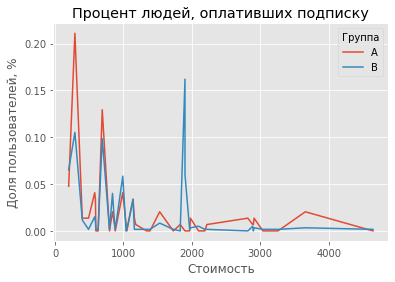

In [17]:
"""Строим график 
Отсекаем ноль, так как большая часть значений находится там и это мешает увидеть данные по активным пользователям"""
df2[1:].plot()
plt.title('Процент людей, оплативших подписку')
plt.xlabel('Стоимость')
plt.ylabel('Доля пользователей, %')
plt.legend(title='Группа')
plt.rcParams['figure.figsize'] = [23, 23]

Цель планируемого А/В-теста: 
Увеличить продажи с помощью новой механики оплаты


Проверим нормальность распределения

H0 = распределения метрик имеют нормальную форму

H1 = распределения метрик имеют ненормальную форму


In [18]:
control = df.query('grp == "A"')['rev'].values
test = df.query('grp == "B"')['rev'].values

In [19]:
"""Для чеков"""
c_gr1 = stats.shapiro(df.query('grp == "A"')['rev'].values)
c_gr2 = stats.shapiro(df.query('grp == "B"')['rev'].values)
print('pvalue для группы А', round(c_gr1[1], 4), 'pvalue для группы B', round(c_gr2[1], 4))

pvalue для группы А 0.0 pvalue для группы B 0.0


/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [20]:
"""Для чеков активных пользователей"""
c_a_gr1 = stats.shapiro(df.query('active == "active" & grp == "A"')['rev'].values)
c_a_gr1 = stats.shapiro(df.query('active == "active" & grp == "B"')['rev'].values)
print('pvalue для группы А', round(c_a_gr1[1], 4), 'pvalue для группы B', round(c_a_gr1[1], 4))

pvalue для группы А 0.0 pvalue для группы B 0.0


In [21]:
"""Для чеков активных пользователей, совершивших покупку"""
c_b_gr1 = stats.shapiro(df.query('active == "active" & rev != 0 &grp == "A"')['rev'].values)
c_b_gr2 = stats.shapiro(df.query('active == "active" & rev != 0 &grp == "B"')['rev'].values)
print('pvalue для группы А', round(c_b_gr1[1], 4), 'pvalue для группы B', round(c_b_gr1[1], 4))

pvalue для группы А 0.0 pvalue для группы B 0.0


Для всех случаев pvalue<0, а значит мы отвергаем нулевую гипотезу.

Вывод
Распределения двух групп для всех метрик имеет ненормальное распределение, так как во всех случаях p-value < 0.05

Отклоняем гипотезу H0 

<h3>Считаем метрики и формулируем гипотезу<h4>

Нулевая гипотеза (H0):
Изменение механики не повлияет на количество продаж 

Альтернативная гипотеза (H1): 
Измение механики приведет к росту продаж

Принимаем стандартные значения 0.05 для p-value и 0.8 для мощности



C учетом имеющихся данных, исcледуемыми метриками могли бы стать - CR и ARPU, ARPAU

<h2>Конверсия

Для проверки гипотезы я использую критерий Хи-квадрат, так как переменные категориальные

In [22]:
"""1) Split groups into two separate DataFrames"""
a = df.query('grp == "A"')
b = df.query('grp == "B"')
""" 2) A-click, A-noclick, B-click, B-noclick"""
a_click = a.query('rev!=0').id.count()
a_noclick = a.id.size - a.query('rev!=0').id.count()
b_click = b.query('rev!=0').id.count()
b_noclick = b.id.size - b.query('rev!=0').id.count()
""" 3) Create np array"""
T = np.array([[a_click, a_noclick], [b_click, b_noclick]])

In [23]:
import scipy
from scipy import stats
print('pvalue =', scipy.stats.chi2_contingency(T, correction=False)[1])

pvalue = 0.964356694967037


Так как pvalue > 0.05, мы принимаем нулевую гипотезу об отсутсвии взаимосвязи

In [24]:
con_test = len(df.query('rev != 0 & grp == "A"')) * 100 / len(df.query('grp == "A"'))
con_control = len(df.query('rev != 0 & grp == "B"')) * 100 / len(df.query('grp == "B"'))

In [25]:
(con_test / con_control)
""" При рассчете конверсий значительной разницы тоже не наблюдается """

' При рассчете конверсий значительной разницы тоже не наблюдается '

Для оставшихся метрик воспользуемся бустрапом, так как все метрики распределены ненормально 
t-test можно воспользоваться при ненормальном распределении, если распределения средних стремятся к нормальному, что мы и проверяем с помощью бутстрапа

Гипотезы для метрик:

H0: в выборке средний чек/ARPU/ARPPU доход (rev) различаются 
H1: в выборке средний чек/ARPU/ARPPU доход (rev) не различаются 


<h2> Средний чек

In [26]:
""" Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа """

' Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа '

In [27]:
def get_bootstrap(
    # числовые значения первой выборки 
    data_column_1, 
    # числовые значения второй выборки
    data_column_2,
    # количество бутстрэп-подвыборок
    boot_it=1000, 
    # интересующая нас статистика
    statistic=np.mean, 
    # уровень значимости
    bootstrap_conf_level=0.95 
):
    boot_data = []
    for i in tqdm(range(boot_it)): 
        # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            # параметр возвращения
            replace=True 
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black') 
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

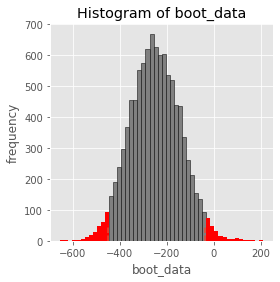

In [28]:
plt.figure(figsize=(4, 4))
bootstrap_check = get_bootstrap(df.query('grp == "A" & rev > 0').rev, \
                                df.query('grp == "B" & rev > 0 ').rev, boot_it=10000)

In [29]:
df

,id,grp,active,rev
0,1489,B,0,0.0
1,1627,A,active,990.0
2,1768,B,0,0.0
3,1783,B,0,0.0
4,1794,A,0,0.0
...,...,...,...,...
74571,200247820,B,0,0.0
74572,201032527,B,0,0.0
74573,201067612,B,0,0.0
74574,201067653,B,0,0.0


In [30]:
if bootstrap_check["p_value"] < 0.05:
    print('Разница между группами отсуствует')
else:
    print('Разница между группами присутствует')
print('Ноль входит в доверительный интервал')

Разница между группами отсуствует
Ноль входит в доверительный интервал


Далее мы можем использовать ttest, так как разница средних стремится к нормальному распределению

In [31]:
"""Проверяем равенство дисперсий"""
stats.levene(df.query('grp == "A" & rev != 0').rev, df.query('grp == "B" & rev != 0 ').rev)
"""pvalue<0.05, a значит дисперсии не равны"""

'pvalue<0.05, a значит дисперсии не равны'

In [32]:
"""Проводим ttest"""
stats.ttest_ind(df.query('grp == "A" & rev > 0').rev, df.query('grp == "B" & rev > 0 ').rev, equal_var=False)

Ttest_indResult(statistic=-2.8670185482728643, pvalue=0.004731862454849822)

В обоих случаях pvalue < 0.05, что позволяет нам принять альтернативную гипотезу. Cредние чеки в двух группах различаются

В качестве способа интерпретировать размер эффекта широко используетсярасчет значения d – Коэна,  формула его достаточно проста и значение d может быть легко рассчитано без применения сложных компьютерных статистических программ при известных значениях средних и стандартных отклонений. 

In [33]:
c0 = df.query('grp == "A" & rev > 0').rev.values
c1 = df.query('grp == "B" & rev > 0').rev.values
cohen = (mean(c0) + mean(c1)) / (sqrt((stdev(c0) ** 2 + stdev(c1) ** 2) / 2))
print('Эффект Коэна равен', round(cohen, 2))
print('Cредний чек группы А', round(mean(c0), 2), 'Cредний чек группы B', round(mean(c1), 2))

Эффект Коэна равен 2.53
Cредний чек группы А 860.71 Cредний чек группы B 1108.82


До настоящего времени не существует определенных стандартов, как оценивать величину размера эффекта. Однако, если следовать методическим рекомендациям наш эффект можно интерпритировать как большой

<h2> ARPU

In [34]:
# доход/число пользователей

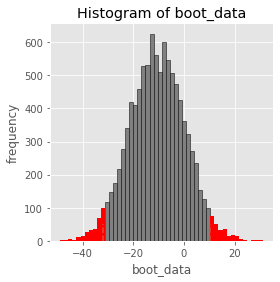

In [35]:
plt.figure(figsize=(4, 4))
bootstrap_arpu = get_bootstrap(
            df.query('active == "active"  & grp == "A"').rev,
            df.query('active == "active"  & grp == "B"').rev,
            boot_it=10000)

In [36]:
if bootstrap_arpu["p_value"] < 0.05:
    print('Разница между группами отсуствует')
else:
    print('Разница между группами присутствует')
print('Ноль не входит в доверительный интервал')

Разница между группами присутствует
Ноль не входит в доверительный интервал


In [37]:
stats.levene(df.query('active == "active" & grp == "A"').rev, \
             df.query('active == "active" & grp == "B"').rev)
"""pvalue > 0.05, a значит принимаем нулевую гипотезу => дисперсии равны"""

'pvalue > 0.05, a значит принимаем нулевую гипотезу => дисперсии равны'

In [38]:
stats.ttest_ind(df.query('active == "active" & grp == "A"').rev, df.query('active == "active" & grp == "B"').rev)

Ttest_indResult(statistic=-1.2253411073793445, pvalue=0.22048133326988378)

In [39]:
e0 = df.query('active == "active" & grp == "A"').rev.values
e1 = df.query('active == "active" & grp == "B"').rev.values
cohen_arpu = (mean(e0) + mean(e1)) / (sqrt((stdev(e0) ** 2 + stdev(e1) ** 2) / 2))
print('Эффект Коэна равен', round(cohen_arpu, 2))
print('ARPU группы А', round(mean(e0), 2), 'ARPU группы B', round(mean(e1), 2))

Эффект Коэна равен 0.35
ARPU группы А 47.35 ARPU группы B 58.06


p-value > 0.05

Принимаем H0

Средние по дохходам в выборках ARPU в двух группах не различаются

<h2>ARPPU

In [40]:
# доход/число пользователей

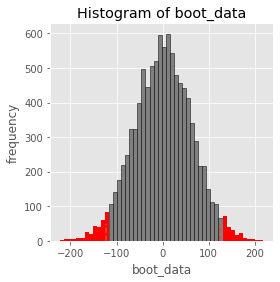

In [41]:
plt.figure(figsize=(4, 4))
bootstrap_arppu = get_bootstrap(
            df.query('active == "active" & grp == "B" & rev > 0').rev,
            df.query('active == "active" & grp == "B" & rev > 0').rev,
            boot_it=10000)

In [42]:
if bootstrap_arppu["p_value"] < 0.05:
    print('Разница между группами отсуствует')
else:
    print('Разница между группами присутствует')
print('Ноль входит в доверительный интервал')

Разница между группами присутствует
Ноль входит в доверительный интервал


In [43]:
stats.levene(df.query('active == "active" & grp == "A" & rev > 0').rev,
             df.query('active == "active" & grp == "B" & rev > 0').rev)

"""pvalue>0.05, a значит дисперсии равны"""

'pvalue>0.05, a значит дисперсии равны'

In [45]:
stats.ttest_ind(df.query('active == "active" & grp == "A" & rev > 0').rev,
                df.query('active == "active" & grp == "B" & rev > 0').rev)

Ttest_indResult(statistic=-3.1337795050930985, pvalue=0.0018562025265765867)

p-value < 0.05
Принимаем H1
Средние по дохходам в выборках ARPU в двух группах различаются

In [46]:
a0 = df.query('active == "active" & grp == "A" & rev > 0').rev.values
a1 = df.query('active == "active" & grp == "B" & rev > 0').rev.values
cohen_arpau = (mean(a0) + mean(a1)) / (sqrt((stdev(a0) ** 2 + stdev(a1) ** 2) / 2))
print('Эффект Коэна равен', round(cohen_arpau, 2))
print('ARPPU группы А', round(mean(a0), 2), 'ARPPU группы B', round(mean(a1), 2))

Эффект Коэна равен 2.55
ARPPU группы А 933.59 ARPPU группы B 1257.88


<h3>Вывод по заданию <h3>

    Изменение механики статистически значимо не повлияло на конверсию покупателей и средний доход от посетителя, однако, мы можем отметить разницу для среднего чека и средний платеж на всех активных пользователей (который считается более точной метрикой нежели ARPU).
    Возможно, cледует сегментировать клиентов и снова проводить АB тестирование. Ну, и, конечно, определиться с эффектом который мы хотим получить, чтобы грамотно определить размеры выборок

<h2>Задание 2. SQL

<h4>2.1 Очень усердные ученики.<h4>

<span style="color:darkblue">2.1.1 Условие

<span style="color:darkblue">Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

<span style="color:darkblue">Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

In [47]:
import pandahouse as ph

In [58]:
""" Объявляем параметры подключения к clickhouse """
connection = dict(database='default.peas',
                  host=' https://clickhouse.lab.karpov.courses',
                  user='student',
                  password='dpo_python_2020')

In [49]:
""" Вкидываем данные (первый столбец - даты (ds), второй - уники (y)) """
query = """
SELECT 
COUNT(st_id) AS Number_of_diligent_students
FROM
(SELECT 
st_id
FROM 
default.peas
WHERE correct = 1
GROUP BY EXTRACT(YEAR FROM timest), EXTRACT(month FROM timest), correct, st_id
HAVING SUM(correct) >= 20)
"""

df = ph.read_clickhouse(query, connection=connection)
df

,Number_of_diligent_students
0,136


<h4>2.2 Оптимизация воронки<h4>

<span style="color:darkblue">2.2.1 Условие

<span style="color:darkblue">Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

<span style="color:darkblue">Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

<span style="color:darkblue">ARPU 
<span style="color:darkblue">ARPAU 
<span style="color:darkblue">CR в покупку 
<span style="color:darkblue">СR активного пользователя в покупку 
<span style="color:darkblue">CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
<span style="color:darkblue">ARPU считается относительно всех пользователей, попавших в группы.

<span style="color:darkblue">Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

<span style="color:darkblue">Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [50]:
query = """
with pilot as 
(select 
st_id as pilot_st 
from 
default.studs
where test_grp = 'pilot'), 

pilot_pay as 
(select 
st_id as pil_pay_st, money
from 
default.final_project_check 
where st_id in (select * from pilot)), 

control as 
(select st_id as control_st 
from 
default.studs
where test_grp = 'control'),

control_pay as 
(select 
st_id as con_pay_st, money 
from 
default.final_project_check
where st_id in (select * from control)),

active as 
(select 
st_id as active_st 
from
(select distinct st_id
from 
default.peas
where correct = 1 
group by st_id
having sum(correct) >= 10)),

active_math as 
(select 
count(st_id) as act_math 
from 
default.final_project_check
where subject = 'Math' 
group by st_id 
having count(money) >= 2),

math_act as 
(select
st_id as act_math, count(subject) 
from 
default.peas
where subject = 'Math' 
group by st_id 
having count(subject) >= 2), 

math as (select st_id 
from default.peas 
where subject = 'Math')

select 
sum(pilot_pay.money)*100/count(distinct st_id) 
FILTER (WHERE st_id in (select * from pilot)) as ARPU_pilot, 
sum(control_pay.money)*100/count(distinct st_id) 
FILTER (WHERE st_id in (select * from control)) as ARPU_control, 
sum(pilot_pay.money)*100/count(distinct st_id) FILTER 
(WHERE st_id in (select pilot_st  from pilot inner join active on pilot.pilot_st = active.active_st)) 
as ARPAU_pilot,
sum(control_pay.money)*100/count(distinct st_id) 
FILTER (WHERE st_id in (select control_st  from control inner join active on control.control_st = active.active_st)) 
as ARPAU_control,
count(distinct pil_pay_st)*100/count(distinct t.st_id)
FILTER (WHERE st_id in (select * from pilot)) as CR_pilot,
count(distinct con_pay_st)*100/count(distinct t.st_id) 
FILTER (WHERE st_id in (select * from control)) as CR_control,
100*count(distinct pil_pay_st) FILTER (WHERE pil_pay_st in 
(select pil_pay_st from pilot_pay inner join active on pilot_pay.pil_pay_st = active.active_st))/count(distinct t.st_id) as CR_act_pilot, 
100*count(distinct con_pay_st) FILTER (WHERE con_pay_st in 
(select con_pay_st from control_pay inner join active on control_pay.con_pay_st = active.active_st))/count(distinct t.st_id) 
as CR_act_control,
100 * count(distinct pil_pay_st) FILTER (WHERE pil_pay_st in (select * from math))/count(distinct st_id) 
FILTER (WHERE st_id in (select * from math) and st_id in (select * from pilot)) as CR_math_pilot, 
100 * count(distinct con_pay_st) FILTER (WHERE con_pay_st in (select * from math))/count(distinct st_id) 
FILTER (WHERE st_id in (select * from math) and st_id in (select * from control)) as CR_math_control 
from default.studs t
left join pilot_pay on t.st_id = pilot_pay.pil_pay_st 
left join control_pay on t.st_id = control_pay.con_pay_st
"""

df2 = ph.read_clickhouse(query, connection=connection)
df2

,ARPU_pilot,ARPU_control,ARPAU_pilot,ARPAU_control,CR_pilot,CR_control,CR_act_pilot,CR_act_control,CR_math_pilot,CR_math_control
0,1.150847e+06,454098.360656,3.361386e+06,1.049242e+06,11.186441,5.245902,4.166667,2.333333,13.333333,11.320755


В первую очередь я разделила данные контрольной и пилотной группы, чтобы рассчитывать метрики для каждой из них было удобнее.
Так же я создала подзапрос для поиска активных пользователей и активных по математике. При первичной обработке стало понятно, что активные пользователи по математике не оплачивали услуги(что означает 0), за СR пользователя из активности по математике, было принято СR пользователей, которые ее проходили и покупали горошины.

По полученным данным можно отметить, что результаты в пилотной группе по всем метрикам лучше и сделать предположение, что новый экран оплаты эфективен

<h2>Задание 3. Python

<span style="color:darkblue">3.1 Задача

<span style="color:darkblue">Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
<span style="color:darkblue">Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [72]:
def authomatical_function(path: str, id_col: str, group_col: str):   
# Загужаем талицы
    groups = pd.read_csv('Проект_2_groups.csv', sep=';')
    groups_add = pd.read_csv('Проект_2_group_add.csv')
    active_st = pd.read_csv('Проект_2_active_studs.csv')
    checks = pd.read_csv('Проект_2_checks.csv', sep=';')   
# Унифицируем названия колонок (если прислали отличные от исходных)
    groups_add.rename(columns={id_col: 'id', group_col: 'grp'}, inplace=True)
    checks = checks.rename(columns={'student_id':  'id'})
    active_st = active_st.rename(columns={'student_id': 'id'})   
# Объединяем дата-сеты
    groups_2 = pd.concat([groups, groups_add], ignore_index=True)
# Добавляем информацию об активности
    active_st['active'] = 'active'
# Объединение дата-фреймов
    df = pd.merge(groups_2, active_st, how='left', on='id')
    df = pd.merge(df, checks, how='left', on='id')
# Заменяем пропуски на нули
    df = df.fillna(0)
# Рассчет метрик
    # Конверсия, средний чек, ARPU, ARPPU
    cr = df.query('rev != 0').groupby('grp', as_index=False).agg({'id': 'count'}).rename(columns={'id': 'buyer'})
    cr['all'] = df.groupby('grp', as_index=False).agg({'id': 'count'}).id.to_list()
    cr['cr'] = round((cr['buyer'] * 100 / cr['all']), 2)   
    check = df.query('rev != 0').groupby('grp', as_index=False).agg({'rev': 'mean'}).round(2).rename(columns={'rev':'avg'})
    check['median'] = df.query('rev != 0').groupby('grp', as_index=False).agg({'rev': 'median'}).round(2).rev.to_list()
    arpu = df.query('active == "active"').groupby('grp', as_index=False).agg({'id': 'count', 'rev': 'sum'}) 
    arpu['arpu'] = round(arpu['rev'] / arpu['id'], 2)      
    arppu = df.query('active == "active" & rev > 0').groupby('grp', as_index=False).agg({'id': 'count', 'rev': 'sum'}).rename(columns={'id': 'active_buyer'})
    arppu['arppu'] = round(arpu['rev'] / arpu['id'], 2)
    s = cr.merge(check, on='grp')
    s = s.merge(arpu, on='grp')
    s = s.merge(arppu, on=['grp', 'rev'])
    # ГРАФИКИ
    # Создаем рамки для графиков
    fig, axes = plt.subplots(3, 2, figsize=(15, 17))
    # Общее название
    fig.suptitle('Графики по получаемым метрикам', fontsize= 15 , fontname="Arial")
    # Названия для отдельных графиков
    axes[0, 0].set_title('CR по группам', fontsize= 15 , loc='left', fontname="Arial")
    axes[0, 1].set_title('Процент людей, оплативших подписку', fontsize= 15 , loc='left', fontname="Arial")
    axes[1, 0].set_title('ARPU по группам', fontsize= 15 , loc='left', fontname="Arial")
    axes[1, 1].set_title('Кол-во пользователей и доход', fontsize= 15 , loc='left', fontname="Arial")
    axes[2, 0].set_title('Cредний чек', fontsize= 15 , loc='left', fontname="Arial")
    axes[2, 1].set_title('Медианный чек', fontsize= 15 , loc='left', fontname="Arial")
    # Рисуем график №1
    sns.barplot(x="grp", y="cr", data=cr, ax=axes[0, 0])
    # Рисуем график №2  
    # Производим вычисления 
    arpu_data = pd.melt(arpu, id_vars='grp', value_vars=['id', 'rev'])
    sns.barplot(x="variable", y="value", hue="grp", data=arpu_data, ax=axes[1, 1])
    # Рисуем график №3
    sns.barplot(x="grp", y="arpu", data=arpu, ax=axes[0, 1])
    # Рисуем график №4
    sns.barplot(x="grp", y="arppu", data=arppu, ax=axes[1, 0])
    # Рисуем график №5
    sns.barplot(x="grp", y="avg", data=check, ax=axes[2, 0])
    # Рисуем график №6
    sns.barplot(x="grp", y="median", data=check, ax=axes[2, 1])   
    # Вывод данных
    return s

,grp,buyer,all,cr,avg,median,id,rev,arpu,active_buyer,arppu
0,A,107,14693,0.73,860.71,690.0,1538,72820.0000,47.35,78,47.35
1,B,434,59883,0.72,1108.82,935.0,6803,394974.0035,58.06,314,58.06


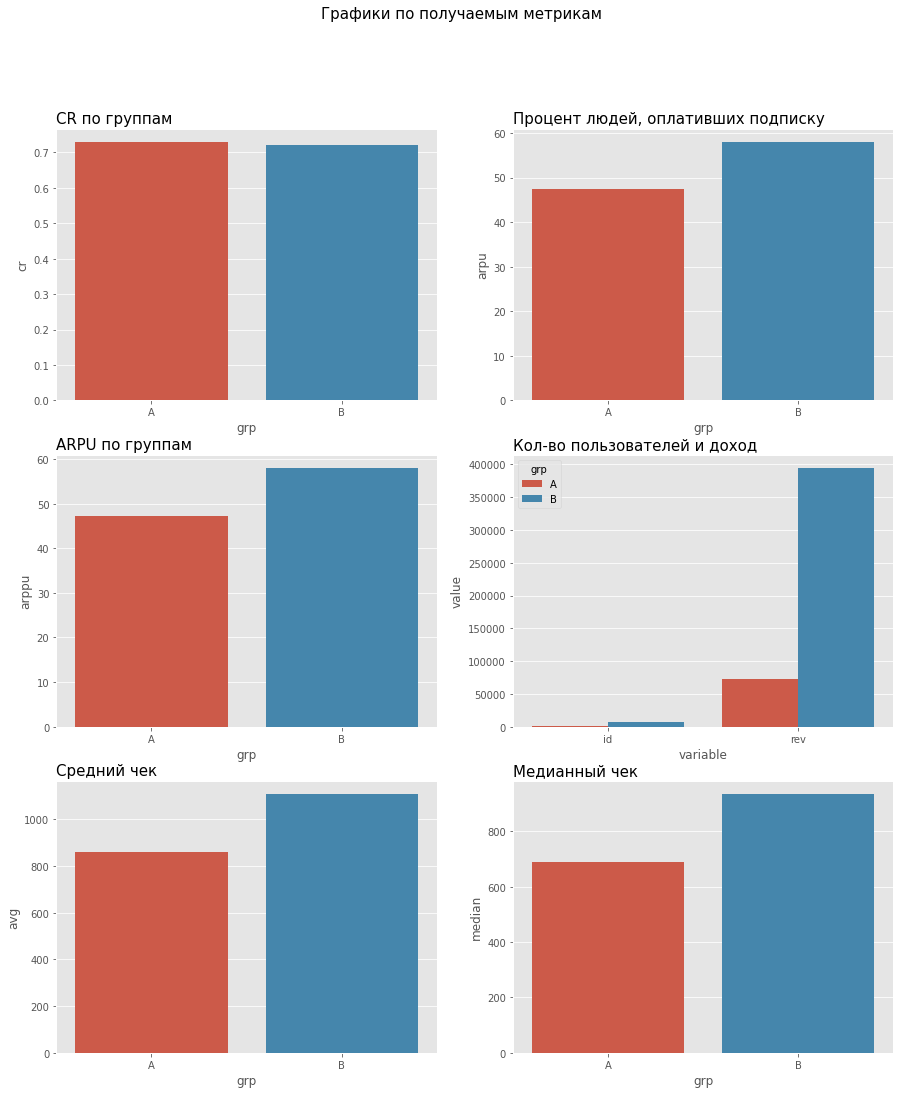

In [73]:
authomatical_function('groups_add.csv', 'id', 'grp')